In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from triangle import triangulate, plot as tplot, convex_hull, show_data, get_data

from random import choice, sample
import matplotlib.colors as mcolors
import dill

In [2]:
t = np.linspace(0, 2*np.pi, 3, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T

In [3]:
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

In [4]:
cndt = triangulate({"vertices":points, "segments":seg}, opts="Rpq30a1.9neo2")

In [15]:
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]
triangles_c = triangles_s.reshape(-1, 2)
a = triangles_s[:, 0] - triangles_s[:, 1] 
b = triangles_s[:, 0] - triangles_s[:, 2] 
areas = np.abs(a[:, 0]*b[:, 1] - a[:, 1]*b[:, 0])

In [6]:
is_boundary_point = np.zeros(points.shape[0], dtype=bool)

boundary_normal = np.zeros((points.shape[0], 2))
boundary_tangential = np.zeros((points.shape[0], 2))

is_set = np.zeros(points.shape[0], dtype=np.bool_)
boundary_triangle = np.zeros_like(is_set, dtype=int)-1

In [7]:
def get_mid(a, b):
    
    if (a == 0) and (b == 1):
        return 5
    if (a == 1) and (b == 2):
        return 3
    if (a == 0) and (b == 2):
        return 4
    
    print(f"{a=}, {b=}")

In [8]:
for index, element in enumerate(triangles):
    
    if (neighbours[index] == -1).sum() == 2:
        indices_ = np.where(neighbours[index] != -1)[0]
        is_boundary_point[element] = True
        is_boundary_point[element[indices_ + 3]]= False
        
    elif (neighbours[index] == -1).sum() == 1:
        
        indices_ = np.where(neighbours[index] != -1)[0]
        is_boundary_point[element[indices_]] = True
        
        origin_point_idx = element[indices_[0]] if is_boundary_point[element[(indices_[0] + 1) % 3]] == True else element[indices_[1]]
        end_point_idx = element[indices_[0]] if origin_point_idx == element[indices_[1]] else element[indices_[1]]
        
        fp = points[origin_point_idx]
        sp = points[end_point_idx]
            
        boundary_normal[origin_point_idx][0] =  -(fp[1] - sp[1])
        boundary_normal[origin_point_idx][1] =  (fp[0] - sp[0])
        
        boundary_tangential[origin_point_idx][0] = (-fp[0] + sp[0])
        boundary_tangential[origin_point_idx][1] = (-fp[1] + sp[1])
        
    
        
        boundary_triangle[origin_point_idx] = index
        
        is_set[origin_point_idx] = True
        
        mid_idx = get_mid(indices_[0], indices_[1])
        
        is_boundary_point[element[mid_idx]] = True
        boundary_normal[element[mid_idx]][0] =  -(fp[1] - sp[1])
        boundary_normal[element[mid_idx]][1] =  +(fp[0] - sp[0])
        
        boundary_tangential[element[mid_idx]][0] = (-fp[0] + sp[0])
        boundary_tangential[element[mid_idx]][1] = (-fp[1] + sp[1])
        
        

for index, element in enumerate(triangles):
    
    if (neighbours[index] == -1).sum() == 2:
        
        set_ = np.where(is_set[element] == True)[0][0]
        
        start_1 = (set_ + 1) % 3
        end_1 = (start_1 + 1) % 3
        
        start_2 = end_1
        end_2 = set_
        
        boundary_normal[element[start_1]][0] =  (points[element[end_1]][1] - points[element[start_1]][1])
        boundary_normal[element[start_1]][1] =  -(points[element[end_1]][0] - points[element[start_1]][0])     
        
        mid_idx = get_mid(end_1, start_1)
        
        boundary_normal[element[mid_idx]][0] =  (points[element[end_1]][1] - points[element[start_1]][1])
        boundary_normal[element[mid_idx]][1] =  -(points[element[end_1]][0] - points[element[start_1]][0])             
        
                
        boundary_normal[element[start_2]][0] =  (points[element[end_2]][1] - points[element[start_2]][1])        
        boundary_normal[element[start_2]][1] =  -(points[element[end_2]][0] - points[element[start_2]][0])
        
        
        mid_idx = get_mid(start_2, end_2)
        
        boundary_normal[element[mid_idx]][0] =  (points[element[end_2]][1] - points[element[start_2]][1])
        boundary_normal[element[mid_idx]][1] =  -(points[element[end_2]][0] - points[element[start_2]][0])             
                
        
        boundary_triangle[element[start_1]] = index
        boundary_triangle[element[start_2]] = index        

boundary_normal[is_boundary_point] = boundary_normal[is_boundary_point] / (boundary_normal[is_boundary_point]**2).sum(axis=-1, keepdims=True) ** 0.5
boundary_tangential[is_boundary_point] = boundary_tangential[is_boundary_point] / (boundary_tangential[is_boundary_point]**2).sum(axis=-1, keepdims=True) ** 0.5

In [9]:
elem_normal = np.zeros((*triangles.shape, 2))
elem_tangential = np.zeros((*triangles.shape, 2))

In [14]:
triangles.shape

(1, 6)

In [10]:
for index, element in enumerate(triangles):
    
    elem_tangential[index, 0][0] = points[element[1]][0]-points[element[0]][0]
    elem_tangential[index, 0][1] = points[element[1]][1]-points[element[0]][1]

    elem_normal[index, 0][0] = points[element[1]][1]-points[element[0]][1]
    elem_normal[index, 0][1] = -(points[element[1]][0]-points[element[0]][0])

    
    elem_tangential[index, 1][0] = points[element[2]][0]-points[element[1]][0]
    elem_tangential[index, 1][1] = points[element[2]][1]-points[element[1]][1]
    
    elem_normal[index, 1][0] = points[element[2]][1]-points[element[1]][1]
    elem_normal[index, 1][1] = -(points[element[2]][0]-points[element[1]][0])    
    
    elem_tangential[index, 2][0] = points[element[0]][0]-points[element[2]][0]
    elem_tangential[index, 2][1] = points[element[0]][1]-points[element[2]][1]
    
    elem_normal[index, 2][0] = points[element[0]][1]-points[element[2]][1]
    elem_normal[index, 2][1] = -(points[element[0]][0]-points[element[2]][0])

    
    mid1 = get_mid(0, 1)
    mid2 = get_mid(1, 2)
    mid3 = get_mid(0, 2)
    
    
    elem_normal[index, mid1][0] = -points[element[0]][1]+points[element[1]][1]
    elem_normal[index, mid1][1] = -(-points[element[0]][0]+points[element[1]][0])

    elem_tangential[index, mid1][0] = (-points[element[0]][0]+points[element[1]][0])
    elem_tangential[index, mid1][1] = -points[element[0]][1]+points[element[1]][1]

    elem_normal[index, mid2][0] = -points[element[1]][1]+points[element[2]][1]
    elem_normal[index, mid2][1] = -(-points[element[1]][0]+points[element[2]][0])

    elem_tangential[index, mid2][0] = (-points[element[1]][0]+points[element[2]][0])
    elem_tangential[index, mid2][1] = -points[element[1]][1]+points[element[2]][1]

    elem_normal[index, mid3][0] = -points[element[2]][1]+points[element[0]][1]
    elem_normal[index, mid3][1] = -(-points[element[2]][0]+points[element[0]][0])

    elem_tangential[index, mid3][0] = (-points[element[2]][0]+points[element[0]][0])
    elem_tangential[index, mid3][1] = -points[element[2]][1]+points[element[0]][1]

In [11]:
elem_normal = elem_normal / (elem_normal**2).sum(axis=-1, keepdims=True) ** 0.5
elem_tangential = elem_tangential / (elem_tangential**2).sum(axis=-1, keepdims=True) ** 0.5

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 290.43it/s]


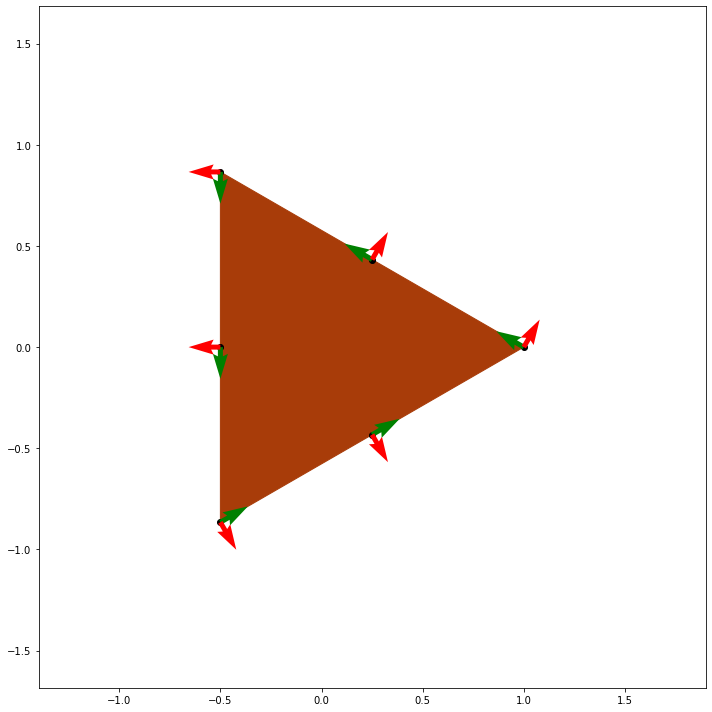

In [12]:
all_colors = list(mcolors.CSS4_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
colors = sample(all_colors, triangles_s.shape[0])
(0)
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("equal")

for index, triangle in enumerate(tqdm(triangles_s[:])):
    t1 = plt.Polygon(triangle[:3], color=colors[index])
    fig.gca().add_patch(t1)
    
    x, y = triangle.mean(axis=0)
#     ax.text(x, y, s=f"{index}", fontsize=20)


for idx, point in enumerate(tqdm(points)):
    pass
#     ax.text(x=point[0]+0.005, y=point[1]+0.05, s=f"{idx}", fontsize=20)
    
for idx, point in enumerate(tqdm(points)):
    if is_boundary_point[idx]:
        ax.scatter(point[0], point[1], color="black", lw=10, s=2)
#         ax.quiver(point[0], point[1], boundary_normal[idx,0], boundary_normal[idx,1], color="red", scale=21)
#         ax.quiver(point[0], point[1], boundary_tangential[idx,0], boundary_tangential[idx,1], color="green", scale=21)
    else:
        ax.scatter(point[0], point[1], color="black")
#         ax.quiver(point[0], point[1], elem_normal[idx,0], elem_normal[idx,1], color="black", scale=21)
#         ax.quiver(point[0], point[1], elem_tangential[idx,0], elem_tangential[idx,1], color="yellow", scale=21)


for idx, elem in enumerate(triangles):
    
    for j in range(6):
        ax.quiver(points[elem[j]][0], points[elem[j]][1], elem_tangential[idx,j,0], elem_tangential[idx,j,1], color="green", scale=21)
        ax.quiver(points[elem[j]][0], points[elem[j]][1], elem_normal[idx,j,0], elem_normal[idx,j,1], color="red", scale=21)
    
    

ax.set_xlim([points[:, 0].min()-1, points[:, 0].max()+1])
ax.set_ylim([points[:, 1].min()-1, points[:, 1].max()+1])

fig.tight_layout()
plt.tight_layout()

plt.show()